<a href="https://colab.research.google.com/github/ReynaldiJ/portfolio/blob/main/BERT_Sentiment_Analysis(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing all necessary libraries
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim

# Data

The dataset used are from the exam package ('/content/Deep Learning and Optimization Final Term Data.zip/Emotion.csv')  for number 2 we are tasked to use BERT for text classification.

In [ ]:
import zipfile
# Extracting from zipped file
zip_file_path = '/content/Deep Learning and Optimization Final Term Data.zip'  # Replace with the path to your zip file
extract_folder = 'extracted_data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
df = pd.read_csv('/content/extracted_data/Emotion.csv', encoding='latin-1')

In [ ]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


From the table head above we can see that this data contains text as the input, and ['joy', 'anger', 'fear', 'surprise', 'love', and 'sadness'] as the label

In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

# Splitting Data

The code below are used to split data into the required form [['train', 'test','split'], [70%, 15%, 15%]]. It is done like how it generally should be.

In [ ]:
# Split the dataset into training, validation, and testing sets
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Pre-processing


The provided code utilizes the 'bert-base-uncased' BERT model for fine-tuning on a downstream text classification task. It employs the Hugging Face Transformers library to tokenize the training, validation, and testing datasets, incorporating settings like truncation and padding. Labels are numerically encoded using pd.factorize. TensorFlow datasets are then created, with the training dataset shuffled and organized into batches. The code ensures consistency in input format for BERT, facilitating efficient training on a labeled dataset for subsequent downstream tasks such as sentiment analysis or classification.

In [ ]:
# Tokenize and prepare input
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128

# Tokenize training, validation, and testing data
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Convert labels to numerical format
train_labels = pd.factorize(train_df['label'])[0]
val_labels = pd.factorize(val_df['label'])[0]
test_labels = pd.factorize(test_df['label'])[0]

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(10000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
for input_data, label in train_dataset.take(5):
    print("Input data:", input_data)
    print("Label:", label)

Input data: {'input_ids': <tf.Tensor: shape=(32, 87), dtype=int32, numpy=
array([[  101,  2026,  2197, ...,     0,     0,     0],
       [  101, 10047,  3110, ...,     0,     0,     0],
       [  101,  1045,  2228, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2215, ...,     0,     0,     0],
       [  101,  1045,  3613, ...,     0,     0,     0],
       [  101,  1045,  2514, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(32, 87), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 87), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype

The provided data represents a batch of inputs and corresponding labels for a BERT-based model. The input data consists of tokenized sequences represented by tensors: input_ids, token_type_ids, and attention_mask, each with a shape of (32, 87), indicating a batch size of 32 and a maximum sequence length of 87 tokens. Padding is evident with zeros at the end of sequences. The labels, shaped (32,), are associated with the input sequences and indicate a multi-class classification task. The label distribution suggests a variety of classes, but there appears to be some class imbalance within the batch.

In [ ]:
print("Original Text:", train_df['text'].iloc[0])
print("Token IDs:", train_encodings['input_ids'][0])
print("Attention Mask:", train_encodings['attention_mask'][0])

Original Text: i woke up i feel thankful to god for giving me another day to go on
Token IDs: tf.Tensor(
[  101  1045  2001  2893 12774  2055  3974  3635  1998  2893  7965  1998
  4147  2008 11018  1998  3110 10392   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0], shape=(87,), dtype=int32)
Attention Mask: tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(87,), dtype=int32)


# Modelling

The provided code initializes a BERT (Bidirectional Encoder Representations from Transformers) model for sequence classification, tailored to the number of unique labels in a dataset. It employs the 'bert-base-uncased' pre-trained variant and configures an Adam optimizer with a learning rate of 2e-5. The model is compiled using sparse categorical cross-entropy loss and accuracy as the evaluation metric. This approach leverages BERT's bidirectional context understanding for natural language tasks, making it suitable for applications like text classification.

In [ ]:
#adapt the code to handle the number of unique emotion labels.
num_labels = len(df['label'].unique())  # Number of unique labels in your dataset
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Define the optimizer, loss function, and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training Model

In [ ]:
history = bert_model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
500/500 [==============================] - 341s 589ms/step - loss: 0.5808 - accuracy: 0.7994 - val_loss: 4.4636 - val_accuracy: 0.1395
Epoch 2/3
500/500 [==============================] - 294s 588ms/step - loss: 0.1519 - accuracy: 0.9389 - val_loss: 5.3099 - val_accuracy: 0.1630
Epoch 3/3
500/500 [==============================] - 293s 585ms/step - loss: 0.1044 - accuracy: 0.9511 - val_loss: 5.8574 - val_accuracy: 0.1590


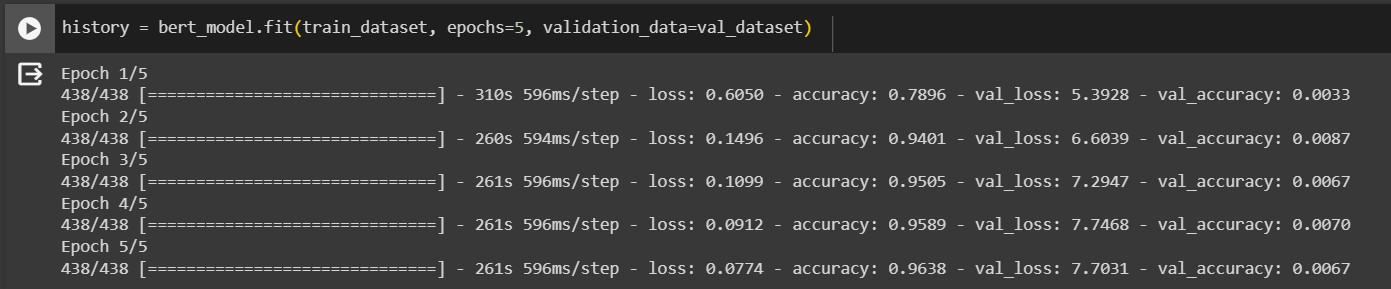

Here I only use 3 epoch instead of 5 epoch because the model overfits at 5 epoch ad it results in lower accuracy.

# Evaluation

* Precision is the ratio of correctly predicted positive instances to the total instances predicted as positive. In general situations, a high precision indicates that when the model predicts a positive outcome, it is likely to be correct

* Recall is the ratio of correctly predicted positive instances to the total actual positive instances. In general situations, a high recall indicates that the model is good at capturing most of the actual positive instances

* The F1-Score is the harmonic mean of precision and recall. It provides a balanced measure of precision and recall. In general situations, a high F1-Score suggests a model that performs well in both precision and recall.

* Accuracy is the ratio of correctly predicted instances to the total instances. In general situations, accuracy provides an overall measure of how well the model is performing across all classes.

In [ ]:
evaluation_results = bert_model.evaluate(test_dataset)

# Print the evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

63/63 [==============================] - 14s 156ms/step - loss: 1.8914 - accuracy: 0.6965
Test Loss: 1.8914270401000977
Test Accuracy: 0.6965000033378601


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Predict the labels on the test set
predictions = bert_model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1)

# Convert the true labels to numpy array
true_labels = test_labels

# Calculate precision, recall, F1-Score, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Accuracy:", accuracy)

63/63 [==============================] - 10s 165ms/step
Precision: 0.7108318068280792
Recall: 0.6965
F1-Score: 0.7031053918997542
Accuracy: 0.6965


* In this case, 71.08% of the predicted positive instances were actually positive. Higher precision indicates a lower rate of false positives.
*  In this case, 69.65% of the actual positive instances were correctly predicted. Higher recall indicates a lower rate of false negatives.
*  The reported F1-Score of 0.7031 suggests a good balance between precision and recall.
* In this case, 69.65% of the instances were correctly classified.

# Prediction

In [ ]:
import numpy as np
input_sentences = [
    "I feel humiliated.",
    "Why are you so stupid",
    "It was very fun",
    "It is very scary",
    "I am feeling happy",
    "i am ever feeling nostalgic about the fireplace i will know that it is still on the property"
]

# Tokenize and prepare input
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_encodings = tokenizer(input_sentences, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Make predictions
predictions = bert_model.predict(dict(input_encodings))

# Extract predicted labels and probabilities
predicted_labels = np.argmax(predictions.logits, axis=1)
predicted_probabilities = tf.nn.softmax(predictions.logits, axis=1).numpy()

# Map numerical labels to corresponding string labels dynamically
labels_mapping = {
    0: 'joy',
    1: 'anger',
    2: 'fear',
    3: 'surprise',
    4: 'love',
    5: 'sadness'
}
predicted_labels_str = [labels_mapping[label] for label in predicted_labels]

# Print predictions
for sentence, label, probability in zip(input_sentences, predicted_labels_str, predicted_probabilities):
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {label}")
    print(f"Predicted Probability: {probability}")
    print()

1/1 [==============================] - 0s 89ms/step
Sentence: I feel humiliated.
Predicted Label: anger
Predicted Probability: [2.2650971e-04 9.9667275e-01 7.6709292e-04 1.9060575e-03 1.9755568e-04
 2.3010765e-04]

Sentence: Why are you so stupid
Predicted Label: anger
Predicted Probability: [0.00776241 0.6770581  0.00428333 0.3082166  0.0010786  0.00160083]

Sentence: It was very fun
Predicted Label: joy
Predicted Probability: [9.9505889e-01 3.5741599e-04 1.9077043e-04 1.2354670e-03 2.0608553e-03
 1.0966141e-03]

Sentence: It is very scary
Predicted Label: fear
Predicted Probability: [0.00238003 0.00686497 0.9499349  0.03534205 0.00106146 0.00441655]

Sentence: I am feeling happy
Predicted Label: joy
Predicted Probability: [9.9859637e-01 1.7190550e-04 1.1143302e-04 1.9598086e-04 6.3768332e-04
 2.8668778e-04]

Sentence: i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Predicted Label: love
Predicted Probability: [3.1365487e-03 6.0940522e-04 8

In [ ]:
import numpy as np

# Get user input sentences
user_input_sentences = []
while True:
    user_sentence = input("Enter a sentence (or type 'exit' to finish): ")
    if user_sentence.lower() == 'exit':
        break
    user_input_sentences.append(user_sentence)

# Tokenize and prepare input
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_encodings = tokenizer(user_input_sentences, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Make predictions
predictions = bert_model.predict(dict(input_encodings))

# Extract predicted labels and probabilities
predicted_labels = np.argmax(predictions.logits, axis=1)
predicted_probabilities = tf.nn.softmax(predictions.logits, axis=1).numpy()

# Map numerical labels to corresponding string labels dynamically
labels_mapping = {
    0: 'joy',
    1: 'anger',
    2: 'fear',
    3: 'surprise',
    4: 'love',
    5: 'sadness'
}
predicted_labels_str = [labels_mapping[label] for label in predicted_labels]

# Print predictions
for sentence, label, probability in zip(user_input_sentences, predicted_labels_str, predicted_probabilities):
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {label}")
    print(f"Predicted Probability: {probability}")
    print()

Enter a sentence (or type 'exit' to finish): i feel like i have to make the suffering i m seeing mean something
Enter a sentence (or type 'exit' to finish): exit
1/1 [==============================] - 0s 44ms/step
Sentence: i feel like i have to make the suffering i m seeing mean something
Predicted Label: anger
Predicted Probability: [2.0240343e-04 9.9763048e-01 6.1281607e-04 8.7689603e-04 4.6417094e-04
 2.1322031e-04]

